### Import Libraries

In [1]:
# Bibliotecas RAPIDS (GPU)
from cuml.preprocessing import StandardScaler
from cuml.pipeline import Pipeline
from cuml.neighbors import KNeighborsClassifier
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier
import xgboost as xgb
from cuml.metrics import accuracy_score
from cuml.metrics import confusion_matrix

# Bibliotecas Scikit-learn (CPU)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold 
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler # Necessário para o MLP na CPU/TF
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
# Defina o número de features que você quer manter
# O dataset tem ~518. Tente começar com 300 ou 400.
K_BEST = 350 

# O seletor "f_classif" (ANOVA) é rápido e geralmente bom. 
# "mutual_info_classif" é mais poderoso (captura relações não-lineares), mas muito mais lento.
selector = SelectKBest(score_func=f_classif, k=K_BEST)

# Bibliotecas de Utilidades
import cupy as cp  # cupy é o "numpy" do RAPIDS
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils

# Bibliotecas TensorFlow
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import gc

# Configuração para não travar a memória da GPU com o TF, permitindo rodar junto com o RAPIDS
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-12-01 01:15:16.174348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Audio Preprocessing

In [2]:
# 1. Carregar os dados oficiais
METADATA_DIR = '../fma_metadata' 
tracks = utils.load(f'{METADATA_DIR}/tracks.csv')
features = utils.load(f'{METADATA_DIR}/features.csv')

# 2. Filtrar pelo dataset 'small'
small_mask = tracks[('set', 'subset')] == 'small'
# A. Lista de gêneros para excluir
genres_to_drop = ['International', 'Instrumental']
# B. Cria uma máscara booleana: True se o gênero NÃO estiver na lista de exclusão
genre_mask = ~tracks[('track', 'genre_top')].isin(genres_to_drop)
# C. Combinar as máscaras (Lógica E: deve ser Small E NÃO ser dos gêneros excluídos)
small_mask = small_mask & genre_mask

X_all_pd = features.loc[small_mask] # Deixar como Pandas DataFrame
y_all_labels_pd = tracks.loc[small_mask, ('track', 'genre_top')] # Deixar como Pandas Series
splits = tracks.loc[small_mask, ('set', 'split')]

y_all_labels_pd = y_all_labels_pd.astype(str)

print(f"Total de faixas 'fma_small': {X_all_pd.shape[0]}")
print(f"Total de features: {X_all_pd.shape[1]}")

# 3. EXTRAIR GRUPOS (ARTIST ID) - NOVO
groups_np = tracks.loc[small_mask, ('artist', 'id')].to_numpy()

# 4. Codificar os Gêneros (Labels) - Usando Sklearn
label_encoder = LabelEncoder()
y_all_encoded_np = label_encoder.fit_transform(y_all_labels_pd).astype(np.int32) # Array Numpy

# 5. Converter X para Numpy (para o loop do sklearn)
X_all_np = X_all_pd.to_numpy()

Total de faixas 'fma_small': 6000
Total de features: 518


In [3]:
# Converta para float32 para economizar RAM e VRAM
X_data = X_all_np.astype(np.float32)
y_data = y_all_encoded_np.astype(np.int32)
groups = groups_np

# Definir número de classes
num_classes = len(np.unique(y_data))

### Treino dos Modelos

In [4]:
def build_reference_mlp(input_shape, num_classes):
    l2_reg = 0.002  # Aumentado de 0.001 para 0.002 (mais penalidade)
    dropout_rate = 0.4 # Aumentado de 0.3 para 0.4 (mais neurônios desligados)
    
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        
        # Camada 1
        layers.Dense(512, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        layers.Dropout(dropout_rate),

        # Camada 2
        layers.Dense(256, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        layers.Dropout(dropout_rate),
        
        # Camada 3
        layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        layers.Dropout(dropout_rate),
        
        # Camada 4
        layers.Dense(64, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        
        # Saída
        layers.Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform')
    ])
    
    # Mantenha o AdamW ou use Adam se der erro de compatibilidade
    # No v1, reduza um pouco o learning rate inicial para 0.0005 para evitar oscilação
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005) 
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [5]:
# 4. Definir a Estratégia de CV
# Usar StratifiedKFold é ideal para classificação, pois mantém
# a proporção de classes em cada fold (o fma_small é balanceado,
# mas esta é uma boa prática).
n_splits = 10
kf = GroupKFold(n_splits=n_splits)

# Teste valores entre 300 e 400 para o SelectKBest.
k_features = 400

# 5. Criar Pipelines para os Modelos
# Isso garante que o StandardScaler seja "fitado" apenas nos dados
# de treino de cada fold, e depois "transforma" os dados de treino e teste.

## Pipeline para KNN
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=200)) # Ajuste os hiperparâmetros aqui
])

## Pipeline para SVM
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovo')) # Ajuste os hiperparâmetros
])

pipe_rf = Pipeline([
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=20)) # Ajuste os hiperparâmetros
])

# 2. XGBoost
model_xgb = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    tree_method='hist',     # Otimizado para GPU
    device="cuda",          # Usa a RTX 3060
    random_state=42,
    objective='multi:softmax',
    num_class=num_classes 
)

# Dicionário de modelos
models = {
    "KNN (GPU)": pipe_knn,
    "SVM (GPU)": pipe_svm,
    "Random Forest (GPU)": pipe_rf,
    "XGBoost (GPU)": model_xgb,
    "MLP (Keras)": "keras_placeholder" # Marcador para lógica especial
}

# Dicionário para guardar os scores de CADA métrica para cada modelo
# Ex: cv_scores['KNN']['Accuracy'] = [0.5, 0.52, ...]
cv_scores = {}

# Dicionário para guardar as previsões e rótulos de todos os folds,
# para a matriz de confusão final
out_of_fold_preds = {}

print(f"Iniciando treinamento com {n_splits} folds...")
print(f"Shape dos dados: {X_all_np.shape}")
print(f"Selecionando as {k_features} melhores features em cada fold...")

for model_name, model in models.items():
    print(f"\nIniciando CV 10-Fold para {model_name}...")
    
    fold_scores_acc = []
    fold_scores_precision = []
    fold_scores_recall = []
    fold_scores_f1 = []
    
    all_y_true = []
    all_y_pred = []

    # Loop de Folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_all_np, y_all_encoded_np, groups=groups_np)):
        # Dados em Numpy (CPU) inicialmente
        X_train, X_test = X_all_np[train_idx], X_all_np[test_idx]
        y_train, y_test = y_all_encoded_np[train_idx], y_all_encoded_np[test_idx]

        # 2. FEATURE SELECTION (SelectKBest)
        selector = SelectKBest(score_func=f_classif, k=k_features)
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)

        y_pred_fold = None # Variável para guardar as previsões deste fold

        # --- LÓGICA ESPECÍFICA POR TIPO DE MODELO ---
        
        # 1. MLP (TensorFlow/Keras)
        if model_name == "MLP (Keras)":
            # Scaling na CPU para o TF
            scaler = SklearnStandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Build & Train
            keras_model = build_reference_mlp(X_train.shape[1], num_classes)
            callbacks_list = [
                # Para se o modelo não melhorar por 8 épocas (evita desperdício)
                EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
                
                # Reduz a taxa de aprendizado se o modelo estagnar (O "Pulo do Gato")
                # Se o loss não cair por 3 épocas, divide o LR por 5. 
                # Isso ajuda o modelo a descer o "vale" do mínimo global com passos menores.
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', 
                    factor=0.2, 
                    patience=3, 
                    min_lr=1e-6,
                    verbose=1
                )
            ]

            # No fit:
            history = keras_model.fit(
                X_train_scaled, y_train,
                epochs=70, # Aumente para dar tempo do ReduceLROnPlateau agir
                batch_size=32,
                validation_split=0.1,
                callbacks=callbacks_list,
                verbose=0
            )
            
            # Predict
            y_probs = keras_model.predict(X_test_scaled, verbose=0)
            y_pred_fold = np.argmax(y_probs, axis=1)
            
            # Limpeza Crítica para GPU 6GB
            tf.keras.backend.clear_session()
            del keras_model, X_train_scaled, X_test_scaled
            gc.collect()

        # 2. Modelos GPU
        elif "(GPU)" in model_name:
            # Converter para CuPy (GPU)
            X_train_cp = cp.array(X_train)
            X_test_cp = cp.array(X_test)
            y_train_cp = cp.array(y_train)
            
            model.fit(X_train_cp, y_train_cp)
            y_pred_cp = model.predict(X_test_cp)
            
            # Trazer de volta para CPU para métricas unificadas depois
            y_pred_fold = cp.asnumpy(y_pred_cp)
            
            # Limpeza
            del X_train_cp, X_test_cp, y_train_cp, y_pred_cp

        # --- MÉTICAS UNIFICADAS ---
        
        # Acurácia (cuml accuracy_score aceita numpy e devolve float ou array 0-d)
        acc = accuracy_score(y_test, y_pred_fold)
        fold_scores_acc.append(acc)
        
        # Calculo dos precision_recall_fscore_support
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(y_test, y_pred_fold, average='macro', zero_division=0)
        
        # Converter métricas scalarem de volta para CPU/float para armazenar na lista
        fold_scores_precision.append(float(macro_p))
        fold_scores_recall.append(float(macro_r))
        fold_scores_f1.append(float(macro_f1))
        
        # Acumular para Matriz Final
        all_y_true.append(y_test)
        all_y_pred.append(y_pred_fold)
    
    # Armazenar resultados do modelo
    cv_scores[model_name] = {
        'Acurácia': np.array(fold_scores_acc),
        'Precisão': np.array(fold_scores_precision),
        'Recall': np.array(fold_scores_recall),
        'F1-Score': np.array(fold_scores_f1)
    }
    
    out_of_fold_preds[model_name] = {
        'y_true': np.concatenate(all_y_true),
        'y_pred': np.concatenate(all_y_pred)
    }
    
    # Limpeza final do modelo
    gc.collect()
    cp.get_default_memory_pool().free_all_blocks()

print("\n--- Avaliação Concluída ---")

Iniciando treinamento com 10 folds...
Shape dos dados: (6000, 518)
Selecionando as 400 melhores features em cada fold...

Iniciando CV 10-Fold para KNN (GPU)...

Iniciando CV 10-Fold para SVM (GPU)...

Iniciando CV 10-Fold para Random Forest (GPU)...

Iniciando CV 10-Fold para XGBoost (GPU)...

Iniciando CV 10-Fold para MLP (Keras)...

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 38: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.

Epoch 41: ReduceLROnPlateau reducing learning rate to 4.000000262749381e-06.
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 35.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 35: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.

Epoch 38: ReduceLROnPlateau reducing learning rate to 4.000000262749381e-06.
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 32.

Epoch 28: ReduceLROn

### Análise de Resultados


========= KNN (GPU) =========
Acurácia       : Média 0.4555 | Std 0.0414
Precisão       : Média 0.5102 | Std 0.0461
Recall         : Média 0.4612 | Std 0.0249
F1-Score       : Média 0.3891 | Std 0.0270

========= SVM (GPU) =========
Acurácia       : Média 0.6068 | Std 0.0342
Precisão       : Média 0.6007 | Std 0.0328
Recall         : Média 0.6144 | Std 0.0254
F1-Score       : Média 0.6014 | Std 0.0302

========= Random Forest (GPU) =========
Acurácia       : Média 0.5603 | Std 0.0399
Precisão       : Média 0.5487 | Std 0.0358
Recall         : Média 0.5665 | Std 0.0321
F1-Score       : Média 0.5496 | Std 0.0330

========= XGBoost (GPU) =========
Acurácia       : Média 0.6045 | Std 0.0318
Precisão       : Média 0.5942 | Std 0.0302
Recall         : Média 0.6107 | Std 0.0250
F1-Score       : Média 0.5963 | Std 0.0282

========= MLP (Keras) =========
Acurácia       : Média 0.5945 | Std 0.0443
Precisão       : Média 0.5884 | Std 0.0413
Recall         : Média 0.6031 | Std 0.0354
F1-Score    

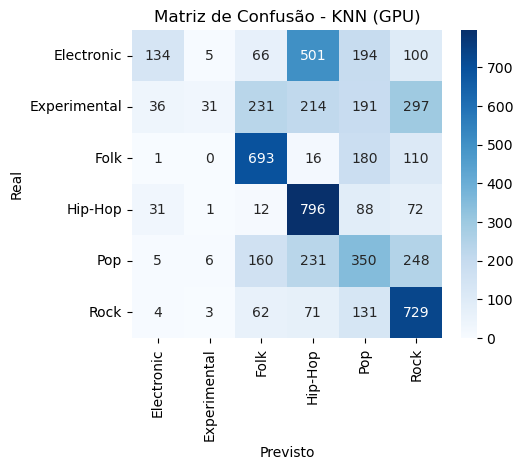

--- SVM (GPU) ---


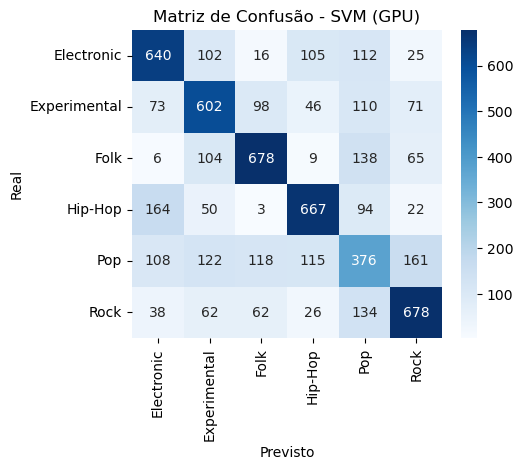

--- Random Forest (GPU) ---


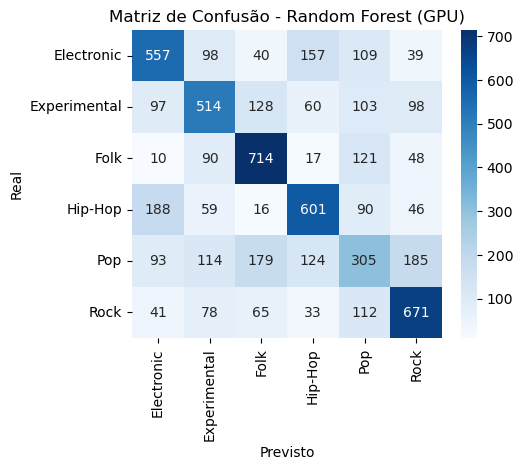

--- XGBoost (GPU) ---


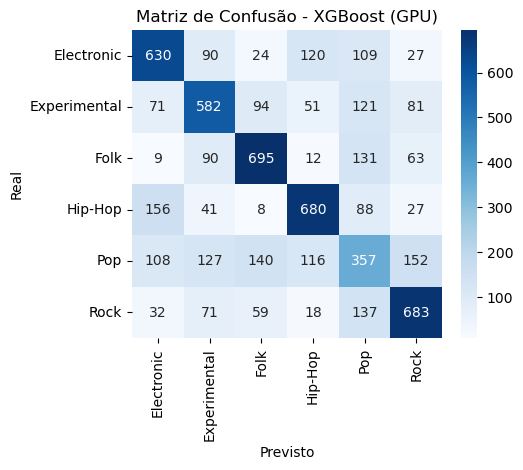

--- MLP (Keras) ---


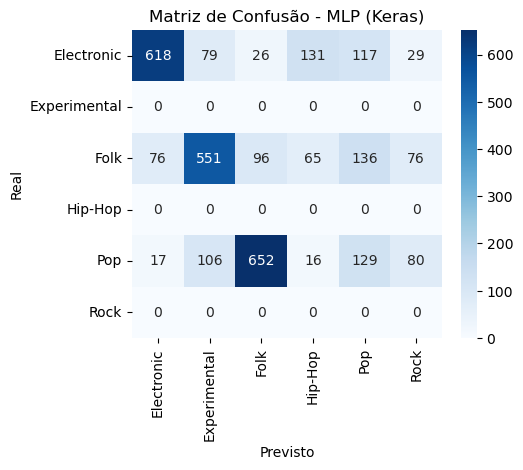

In [6]:
# 4. Exibição dos Resultados
for model_name, metrics in cv_scores.items():
    print(f"\n========= {model_name} =========")
    for metric_name, values in metrics.items():
        print(f"{metric_name:15}: Média {values.mean():.4f} | Std {values.std():.4f}")

# 5. Plot das Matrizes de Confusão
print("\n========= Matrizes de Confusão Agregadas =========")
class_names = label_encoder.classes_ # Nomes dos gêneros

for model_name, results in out_of_fold_preds.items():
    print(f"--- {model_name} ---")
    
    # Calcular CM total usando cuML
    cm_gpu = confusion_matrix(results['y_true'], results['y_pred'])
    cm_cpu = cp.asnumpy(cm_gpu) # Mover para CPU para o Seaborn
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_cpu, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Real')
    plt.xlabel('Previsto')
    plt.show()